In [1]:
!pip install beautifulsoup4
!pip install lxml
!pip install geopy
! pip install folium==0.5.0
!pip install wordcloud
print('Necessary Packages installed')

     |████████████████████████████████| 122kB 3.7MB/s eta 0:00:01
     |████████████████████████████████| 5.5MB 24.2MB/s eta 0:00:01
     |████████████████████████████████| 112kB 9.7MB/s eta 0:00:01
     |████████████████████████████████| 368kB 6.4MB/s eta 0:00:01
Necessary Packages installed


In [2]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
%matplotlib inline 
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize
import folium # plotting library
# import k-means from clustering stage
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries imported.')

Libraries imported.


In [3]:
url = requests.get("https://en.wikipedia.org/wiki/List_of_districts_and_neighborhoods_in_Los_Angeles").text
soup = BeautifulSoup(url,'lxml')
# print(soup.prettify())
tabledata=[]
data =soup.findAll('div',{'class':'div-col'})
# print(data)
for i in data:
    tablecells=i.find_all('a')
#     print(tablecells)
    for tablecell in tablecells:
        row=[tablecell.get_text()]
        if(len(str(row)[2:-2])>4):
            tabledata.append([str(row)[2:-2]+", Los Angeles",0,0])
# print(tabledata)

#Initialising an empty array of columnnames
columnname=["Neighborhood","Latitude","Longitude"]

# Dataframe with 3 columns
dfLA = pd.DataFrame(tabledata, columns = columnname)
print(dfLA.shape)
dfLA.head(10)

(200, 3)


,Neighborhood,Latitude,Longitude
0,"Angelino Heights, Los Angeles",0,0
1,"Angeles Mesa, Los Angeles",0,0
2,"Angelus Vista, Los Angeles",0,0
3,"Arleta, Los Angeles",0,0
4,"Arlington Heights, Los Angeles",0,0
5,"Arts District, Los Angeles",0,0
6,"Atwater Village, Los Angeles",0,0
7,"Baldwin Hills, Los Angeles",0,0
8,"Baldwin Hills/Crenshaw, Los Angeles",0,0
9,"Baldwin Village, Los Angeles",0,0


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>foursquare_agent</em>, as shown below.

In [4]:
for i,neighborhood in enumerate(dfLA['Neighborhood']):
    address = neighborhood
    geolocator = Nominatim(user_agent="foursquare_agent")
    try:
        location = geolocator.geocode(address)
        print(location)
        dfLA.loc[[i],['Latitude']] = location.latitude
        dfLA.loc[[i],['Longitude']] = location.longitude
    except:
        pass

Angelino Heights, Echo Park, Los Angeles, Los Angeles County, California, 90026, United States
Angeles Mesa Branch Los Angeles Public Library, 2nd Avenue, Hyde Park, Los Angeles, Los Angeles County, California, 90008, United States
Crematório Angelus, 565, Avenida Alziro Zarur, Jardim São Jorge, Maringá, Região Geográfica Imediata de Maringá, Região Geográfica Intermediária de Maringá, Paraná, Região Sul, 87080-590, Brasil
Arleta, Los Angeles, Los Angeles County, California, United States
Arlington Heights, Los Angeles, Los Angeles County, California, United States
Arts District, Downtown, Los Angeles, Los Angeles County, California, United States
Atwater Village, Los Angeles, Los Angeles County, California, 90039, United States
Baldwin Hills, Culver City, Los Angeles County, California, 90232, United States
Baldwin Hills/Crenshaw, Los Angeles, Los Angeles County, California, United States
KWKW-AM (Los Angeles), Chesapeake Avenue, Baldwin Hills/Crenshaw, Los Angeles, Los Angeles County

In [5]:
# Dropping Neighborhoods where Latitude and Longitude Values could not be found
try:
    dfLA=dfLA.loc[dfLA['Latitude']>0]
    print(dfLA.shape)
except:
    pass
# # Dropping Neighborhoods where latitude and longitude returned by Nomimatim was of some other city / country
try:
    dfLA=dfLA.loc[abs(dfLA['Latitude']-dfLA['Latitude'].mean())<1.00]
    dfLA=dfLA.loc[abs(dfLA['Latitude']-dfLA['Latitude'].mean())<1.00]
    print(dfLA.shape)
except:
    pass
# try:
#     dfLA=dfLA.loc[abs(dfLA['Longitude']-dfLA['Longitude'].mean())<5]
#     print(dfLA.shape)
# except:
#     pass
dfLA=dfLA.reset_index(drop=True)
# dfLAperm=dfLA



(173, 3)
(164, 3)


In [6]:
address = "Los Angeles, CA, USA"

geolocator = Nominatim(user_agent="toronto_neighborhoodexplorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles city are 34.0536909, -118.242766.


In [7]:
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, neighborhood in zip(
        dfLA['Latitude'], 
        dfLA['Longitude'], 
        dfLA['Neighborhood']):
    label = '{}, Los Angeles, CA, {},{}'.format(neighborhood,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
map_LA


#### We can observe that in some areas of LA city, the neighborhoods are very closely placed to each other.
##### Therefore post careful observation, fixing a threshold of 1/50th of a distance covered by 1 degree of Latitude anywhere on earth or or the distance covered by a degree of Longitude at the equator of the earth, i.e. approx distance of 2.22 kms, we are able to bring down the number of neighborhoods studied to 89 from the initial 164 Neighborhoods

In [8]:
# Dropping neighborhoods which are too close to each other
dropIndexes=[]
for i in range(dfLA.shape[0]):
    for rowdiff in range(1,(len(dfLA['Latitude'])-i)):
#         print(""+str(i)+","+str(rowdiff))
        if((i not in dropIndexes) and ((((dfLA.iat[i,1]-dfLA.iat[i+rowdiff,1])**2+(dfLA.iat[i,2]-dfLA.iat[i+rowdiff,2])**2)**0.50)<0.02)):
            dropIndexes.append(i+rowdiff)
            #         print((((dfLA.iat[i,1]-dfLA.iat[i+rowdiff,1])**2+(dfLA.iat[i,2]-dfLA.iat[i+rowdiff,2])**2)**0.50))
# print(dropIndexes)
x = np.array(dropIndexes) 
print(np.unique(x))
dfLA.drop(dropIndexes,inplace=True)
print("New number of Neighborhoods being explored are: "+str(dfLA.shape[0]))

[  8  12  15  16  19  21  23  26  27  29  30  31  32  36  39  40  43  44
  47  49  51  52  57  62  63  64  65  66  68  70  71  72  76  80  81  82
  83  87  89  91  92  93  97 102 105 107 113 117 118 119 122 124 128 130
 132 133 134 136 140 141 142 143 144 145 146 148 150 152 153 155 156 157
 159 160 161]
New number of Neighborhoods being explored are: 89


#### Let us observe this on the Los Angeles Map.

In [9]:
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)
for lat, lng, neighborhood in zip(
        dfLA['Latitude'], 
        dfLA['Longitude'], 
        dfLA['Neighborhood']):
    label = '{}, Los Angeles, CA, {},{}'.format(neighborhood,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
map_LA

### Repeating this process for Greater London Area
#### The data for Greater London was obtained from https://www.doogal.co.uk which had the most exhaustive postal codes among many other websites list similar information.

In [10]:
#Reading the CSV to a Pandas dataframe
# !wget -O London_Postcodes.csv https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London
df=pd.read_csv('London_Postcodes.csv')
print(df.shape)
df.head(10)
dfGL=df.loc[df['In Use?']=="Yes"]
print(dfGL.shape)
dfGL['Neighborhood']=dfGL['Postcode district']+", "+dfGL['District']
dfGL=dfGL[['Neighborhood','Latitude','Longitude']]
print(dfGL.shape)
dfGL=dfGL.reset_index(drop=True)
# dfGL.head(50)
dfLondon=pd.DataFrame()
dfLondon=dfGL.groupby(['Neighborhood'], as_index=False).mean()
dfLondon.rename(columns={'Neighborhood':'Neighborhood'},inplace=True)
print(dfLondon.shape)
dfLondon.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(323306, 49)
(179130, 49)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(179130, 3)
(558, 3)


,Neighborhood,Latitude,Longitude
0,"BR1, Bromley",51.408148,0.025313
1,"BR1, Lewisham",51.426757,0.003879
2,"BR2, Bromley",51.387282,0.022406
3,"BR3, Bromley",51.404544,-0.030594
4,"BR3, Croydon",51.378711,-0.027304


In [11]:
Londonaddress = "City of London, Greater London, UK"

geolocator = Nominatim(user_agent="toronto_neighborhoodexplorer")
locationlondon = geolocator.geocode(Londonaddress)
latitudelondon = locationlondon.latitude
longitudelondon = locationlondon.longitude
print('The geograpical coordinates of Greater London are {}, {}.'.format(latitudelondon, longitudelondon))

The geograpical coordinates of Greater London are 51.5156177, -0.0919983.


In [12]:
map_London = folium.Map(location=[latitudelondon, longitudelondon], zoom_start=10)
for lat, lng, neighborhood in zip(
        dfLondon['Latitude'], 
        dfLondon['Longitude'], 
        dfLondon['Neighborhood']):
    label = '{}, Greater London, UK, {},{}'.format(neighborhood,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)  
map_London


#### We can observe that in some areas of Greater London, the neighborhoods are very closely placed to each other.
##### Therefore post careful observation, fixing a threshold of 1/50th of a distance covered by 1 degree of Latitude anywhere on earth or or the distance covered by a degree of Longitude at the equator of the earth, i.e. approx distance of 2.22 kms, we are able to bring down the number of neighborhoods studied to 204 from the initial 558 Neighborhoods

In [13]:
# Dropping neighborhoods which are too close to each other
dropIndexes=[]
for i in range(dfLondon.shape[0]):
    for rowdiff in range(1,(len(dfLondon['Latitude'])-i)):
#         print(""+str(i)+","+str(rowdiff))
        if((i not in dropIndexes) and ((((dfLondon.iat[i,1]-dfLondon.iat[i+rowdiff,1])**2+(dfLondon.iat[i,2]-dfLondon.iat[i+rowdiff,2])**2)**0.50)<0.02)):
            dropIndexes.append(i+rowdiff)
            #         print((((dfLA.iat[i,1]-dfLA.iat[i+rowdiff,1])**2+(dfLA.iat[i,2]-dfLA.iat[i+rowdiff,2])**2)**0.50))
# print(dropIndexes)
x = np.array(dropIndexes) 
print(np.unique(x))
dfLondon.drop(dropIndexes,inplace=True)
print("New number of Neighborhoods being explored are: "+str(dfLondon.shape[0]))

[  5   6  10  20  22  27  28  32  33  38  42  44  48  49  54  59  60  61
  62  63  64  65  67  68  69  70  71  72  76  78  80  81  83  84  85  86
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 150 154 157 166 169 172 173 177 178 179 182 187 189 193
 198 199 200 201 202 204 206 209 210 211 212 215 217 219 221 222 225 226
 227 228 229 230 231 233 234 235 236 237 240 241 242 243 244 246 247 248
 249 252 253 254 256 260 262 263 266 267 270 271 272 273 274 276 277 278
 281 289 293 294 296 298 300 301 304 306 307 308 310 311 313 315 316 318
 321 323 324 325 326 328 329 331 332 334 335 336 337 338 339 340 341 345
 346 347 348 349 351 352 353 354 355 356 358 359 360 362 363 365 366 369
 370 372 376 378 380 381 382 385 387 389 390 391 392 393 394 395 396 397
 399 400 401 402 403 404 406 407 408 409 410 411 41

In [14]:
map_London = folium.Map(location=[latitudelondon, longitudelondon], zoom_start=10)
for lat, lng, neighborhood in zip(
        dfLondon['Latitude'], 
        dfLondon['Longitude'], 
        dfLondon['Neighborhood']):
    label = '{}, Greater London, UK, {},{}'.format(neighborhood,lat,lng)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)  
map_London

#### Now that we have obtained the latitudes and longitudes of 89 Neighborhoods in Los Angeles and 204 Neighborhoods likewise in Greater London, we are in a position to explore these venues further to draw some conclusions about their similarities and differences.
##### We will be using Foursquare API for the exploration exercise. Let's dive in!

## Foursquare API - Neighborhood Clustering - City Of Los Angeles

In [15]:
#Defining Foursquare Credentials
CLIENT_ID = 'RYWMXCKA42CXTOONMYFSMOGE05ONNGWKRTVZYVWMD1E4K5KP' # your Foursquare ID
CLIENT_SECRET = 'VUFZHNXYDLA3A3Y2ZK5LMULZ4QGP0JU3GDSOG3MZ0RKPAJ3S' # your Foursquare Secret
VERSION = '20180604'

#Exploring First Neighborhood in Los Angeles Data
neighborhood_name = dfLA.loc[0, 'Neighborhood']
print(f"The first neighborhood's name is '{neighborhood_name}'.")

The first neighborhood's name is 'Angelino Heights, Los Angeles'.


### Exploring the first Neighborhood in Los Angeles
#### - Fetching Latitude and Longitude of this neighborhood

In [16]:
neighborhood_latitude = dfLA.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfLA.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Angelino Heights, Los Angeles are 34.0702889, -118.2547965.


##### Fetching the top 50 Venues that are in and around 1000 Meters in from the centre point of this first Neighborhoods in LA.

In [23]:
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()
# results

In [24]:
#Defining the function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
#Cleaning the Json and structuring it into a pandas dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Halliwell Manor,Performing Arts Venue,34.069329,-118.254165
1,Guisados,Taco Place,34.070262,-118.250437
2,Eightfold Coffee,Coffee Shop,34.071245,-118.250698
3,Subliminal Projects,Art Gallery,34.072290,-118.250737
4,Ototo,Sake Bar,34.072659,-118.251740
5,Button Mash,Arcade,34.073975,-118.251507
6,Tsubaki,Japanese Restaurant,34.072938,-118.251298
7,Konbi,Japanese Restaurant,34.075383,-118.253893
8,Leo's Tacos,Taco Place,34.067743,-118.260974
9,Sunset Beer Company,Beer Store,34.075478,-118.255311


In [26]:
# Repeating this process by defining a function the get the nearby top 100 venues for each neighbourhood in Los Angeles
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [27]:
#Storing the nearby venues obtained using a call to the above function in to a new data frame

dfLAVenues = getNearbyVenues(names=dfLA['Neighborhood'],
                                   latitudes=dfLA['Latitude'],
                                   longitudes=dfLA['Longitude']
                                  )
dfLAVenues.shape

(3135, 7)

In [28]:
#Checking the count of venues returned for each neighborhood
dfLAVenues.groupby('Neighborhood').count()
# dfLAVenues.shape

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Angeles Mesa, Los Angeles",34,34,34,34,34,34
"Angelino Heights, Los Angeles",50,50,50,50,50,50
"Arleta, Los Angeles",12,12,12,12,12,12
"Arlington Heights, Los Angeles",40,40,40,40,40,40
"Arts District, Los Angeles",50,50,50,50,50,50
...,...,...,...,...,...,...
"Westchester, Los Angeles",50,50,50,50,50,50
"Westwood, Los Angeles",50,50,50,50,50,50
"Wilmington, Los Angeles",26,26,26,26,26,26


##### Note that, basis the names of all the 89 Neighborhoods which we had selected, we could find the Venues for 88 Neighborhoods. The one Neighborhood for which no venues could be found on Foursquare database would be ignored from our Analysis.

In [29]:
#Counting the number of unique categories of venues obtained from all these neighborhoods
print('There are {} unique categories.'.format(len(dfLAVenues['Venue Category'].unique())))

There are 319 unique categories.


In [30]:
#Analyzing each neighborhood
# one hot encoding
LA_onehot = pd.get_dummies(dfLAVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = dfLAVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

,Yoga Studio,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Aquarium,Arcade,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#Grouping rows by neighborhoods and taking mean frequency of occurence of each venue category should give us a No Of Neighborhoods X No of Unique Venue Categories size dataset
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Airport,Airport Terminal,American Restaurant,Amphitheater,Andhra Restaurant,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Watch Shop,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Angeles Mesa, Los Angeles",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000,0.029412,0.029412,0.0,0.0,0.0,0.029412,0.0,0.0,0.0
1,"Angelino Heights, Los Angeles",0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,0.0,...,0.020,0.000000,0.000000,0.0,0.0,0.0,0.020000,0.0,0.0,0.0
2,"Arleta, Los Angeles",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.000,0.000000,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,"Arlington Heights, Los Angeles",0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.025,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,"Arts District, Los Angeles",0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,...,0.040,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [32]:
#Function for checking the 10 most frequent venues of each category
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
LAneighborhoods_venues_sorted = pd.DataFrame(columns=columns)
LAneighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    LAneighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

print(LAneighborhoods_venues_sorted.shape)
LAneighborhoods_venues_sorted.head(25)


(88, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Angeles Mesa, Los Angeles",Playground,Fried Chicken Joint,Chinese Restaurant,Mobile Phone Shop,Pharmacy,Burger Joint,Liquor Store,Restaurant,Hardware Store,Marijuana Dispensary
1,"Angelino Heights, Los Angeles",Coffee Shop,Bar,Japanese Restaurant,Mexican Restaurant,Breakfast Spot,Taco Place,American Restaurant,Park,Art Gallery,Pizza Place
2,"Arleta, Los Angeles",Taco Place,Home Service,Historic Site,Ice Cream Shop,Video Store,Liquor Store,Convenience Store,Mexican Restaurant,Fast Food Restaurant,Asian Restaurant
3,"Arlington Heights, Los Angeles",Korean Restaurant,Mexican Restaurant,Rental Car Location,Italian Restaurant,Latin American Restaurant,Coffee Shop,Nightclub,Food,Donut Shop,Bakery
4,"Arts District, Los Angeles",Cocktail Bar,Coffee Shop,Ice Cream Shop,Italian Restaurant,Art Gallery,Bookstore,Brewery,Grocery Store,Vegetarian / Vegan Restaurant,German Restaurant
5,"Atwater Village, Los Angeles",Coffee Shop,Pizza Place,Vietnamese Restaurant,Gym,Mediterranean Restaurant,Gym / Fitness Center,Liquor Store,Indie Theater,Gaming Cafe,New American Restaurant
6,"Baldwin Hills, Los Angeles",New American Restaurant,Park,Food Truck,Dog Run,Comedy Club,Big Box Store,Chinese Restaurant,Furniture / Home Store,Scenic Lookout,Garden
7,"Baldwin Hills/Crenshaw, Los Angeles",Clothing Store,Chinese Restaurant,Park,Athletics & Sports,Mobile Phone Shop,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Sandwich Place
8,"Beachwood Canyon, Los Angeles",Trail,Gym / Fitness Center,Scenic Lookout,Photography Studio,Speakeasy,Cave,Sculpture Garden,Café,Grocery Store,Entertainment Service
9,"Benedict Canyon, Los Angeles",Lawyer,Park,Playground,Field,Baseball Field,Golf Course,Gym Pool,Tennis Court,Boutique,Fast Food Restaurant


## Trying to find the optimum number of Clusters for K means using a combination of Elbow Method and Silhoutte method

[[2, 0.49630872876054594], [3, 0.05614868067151033], [4, 0.3004198605137775], [5, 0.1283492416863406], [6, 0.11489671331968027], [7, 0.08377097910508328], [8, 0.06987375632914695], [9, 0.05417113597054188], [10, 0.06266620145750613]]
[[2, 4.438952557620235], [3, 4.208577917192577], [4, 3.876011614021709], [5, 3.761309905071356], [6, 3.5820364369613436], [7, 3.314748894253186], [8, 3.2122339146867103], [9, 2.9640280697079304], [10, 2.862376810026356]]


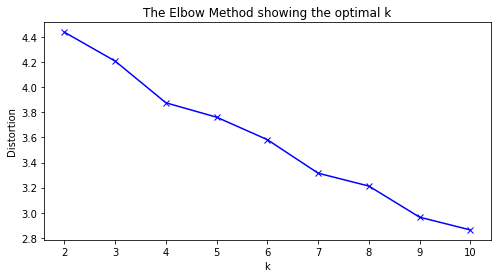

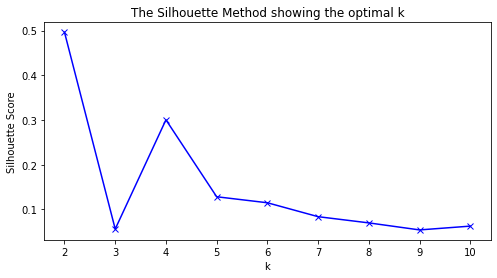

In [40]:
LA_grouped_clustering = LA_grouped.drop('Neighborhood', axis=1)
# function returns WSS score for k values from 1 to kmax
distortions=[]
sil=[]
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
%matplotlib inline 
K = range(2,11)
for k in K:
    kmeanModel = KMeans(init="k-means++",n_clusters=k,n_init=8)
    kmeanModel.fit(LA_grouped_clustering)
    distortions.append([k,kmeanModel.inertia_])
    labels = kmeanModel.labels_
    sil.append([k,silhouette_score(LA_grouped_clustering, labels, metric = 'euclidean')])
    
print(sil)
print(distortions)
plt1.figure(figsize=(8,4))
distortionT=list(zip(*distortions))
plt1.plot(K, distortionT[1], 'bx-')
plt1.xlabel('k')
plt1.ylabel('Distortion')
plt1.title('The Elbow Method showing the optimal k')
plt1.show()

plt2.figure(figsize=(8,4))
silT=list(zip(*sil))
plt2.plot(K, silT[1], 'bx-')
plt2.xlabel('k')
plt2.ylabel('Silhouette Score')
plt2.title('The Silhouette Method showing the optimal k')
plt2.show()
#Clustering neighborhoods for k Means clustering 
# set number of clusters
# kclusters = 5


## Performing K Means Clustering with 4 Cluster Labels basis the above observation of Elbow and silhouette score at k=4

In [41]:
#Clustering neighborhoods for k Means clustering 
# set number of clusters
kclusters = 4
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 0, 1, 1, 1, 1, 0, 3, 2], dtype=int32)

In [42]:
#Creating a new dataframe with top 10 venue categories that are most available in each neighborhood
# add clustering labels
LAneighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

LA_merged = dfLA

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
LA_merged = LA_merged.join(LAneighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
LA_merged=LA_merged.dropna(axis=0)
LA_merged.Cluster_Labels=LA_merged.Cluster_Labels.astype('int')
LA_merged.head(25) # check the last columns!
# LA_merged.dtypes
# LA_merged.head()

,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Angelino Heights, Los Angeles",34.070289,-118.254796,1,Coffee Shop,Bar,Japanese Restaurant,Mexican Restaurant,Breakfast Spot,Taco Place,American Restaurant,Park,Art Gallery,Pizza Place
1,"Angeles Mesa, Los Angeles",33.991402,-118.319520,0,Playground,Fried Chicken Joint,Chinese Restaurant,Mobile Phone Shop,Pharmacy,Burger Joint,Liquor Store,Restaurant,Hardware Store,Marijuana Dispensary
2,"Arleta, Los Angeles",34.241327,-118.432205,0,Taco Place,Home Service,Historic Site,Ice Cream Shop,Video Store,Liquor Store,Convenience Store,Mexican Restaurant,Fast Food Restaurant,Asian Restaurant
3,"Arlington Heights, Los Angeles",34.043494,-118.321374,1,Korean Restaurant,Mexican Restaurant,Rental Car Location,Italian Restaurant,Latin American Restaurant,Coffee Shop,Nightclub,Food,Donut Shop,Bakery
4,"Arts District, Los Angeles",34.041239,-118.234450,1,Cocktail Bar,Coffee Shop,Ice Cream Shop,Italian Restaurant,Art Gallery,Bookstore,Brewery,Grocery Store,Vegetarian / Vegan Restaurant,German Restaurant
5,"Atwater Village, Los Angeles",34.116398,-118.256464,1,Coffee Shop,Pizza Place,Vietnamese Restaurant,Gym,Mediterranean Restaurant,Gym / Fitness Center,Liquor Store,Indie Theater,Gaming Cafe,New American Restaurant
6,"Baldwin Hills, Los Angeles",34.017616,-118.381694,1,New American Restaurant,Park,Food Truck,Dog Run,Comedy Club,Big Box Store,Chinese Restaurant,Furniture / Home Store,Scenic Lookout,Garden
7,"Baldwin Hills/Crenshaw, Los Angeles",34.012748,-118.354724,0,Clothing Store,Chinese Restaurant,Park,Athletics & Sports,Mobile Phone Shop,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Sandwich Place
9,"Beachwood Canyon, Los Angeles",34.122292,-118.321384,3,Trail,Gym / Fitness Center,Scenic Lookout,Photography Studio,Speakeasy,Cave,Sculpture Garden,Café,Grocery Store,Entertainment Service
10,"Benedict Canyon, Los Angeles",34.044770,-118.400022,2,Lawyer,Park,Playground,Field,Baseball Field,Golf Course,Gym Pool,Tennis Court,Boutique,Fast Food Restaurant


In [43]:
# Optional code to check if there are still any null values in the common venues dataframe.
# This is relevant to be checked upon later executions since the venues are time-dependent and not absolute over a scale of a few years.
# bool_series = pd.isnull(LA_merged["Cluster Labels"])
# LA_merged[bool_series]

In [44]:
#Visualizing the resulting CLusters
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_merged['Latitude'],LA_merged['Longitude'],LA_merged['Neighborhood'],LA_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ', Cluster --> ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1-2],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Inspecting the types of Venues based on Clusters

In [45]:
#Inspecting Cluster 1
LA_merged_cluster1=LA_merged.loc[LA_merged['Cluster_Labels'] == 0, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
LA_merged_cluster1.reset_index(drop=True,inplace=True)
print('Cluster 1 has '+str(LA_merged_cluster1.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(LA_merged_cluster1.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud1LA = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
LA_merged_cluster1

Cluster 1 has 40 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Angeles Mesa, Los Angeles",Playground,Fried Chicken Joint,Chinese Restaurant,Mobile Phone Shop,Pharmacy,Burger Joint,Liquor Store,Restaurant,Hardware Store,Marijuana Dispensary
1,"Arleta, Los Angeles",Taco Place,Home Service,Historic Site,Ice Cream Shop,Video Store,Liquor Store,Convenience Store,Mexican Restaurant,Fast Food Restaurant,Asian Restaurant
2,"Baldwin Hills/Crenshaw, Los Angeles",Clothing Store,Chinese Restaurant,Park,Athletics & Sports,Mobile Phone Shop,Pizza Place,Fast Food Restaurant,Fried Chicken Joint,Supermarket,Sandwich Place
3,"Boyle Heights, Los Angeles",Mexican Restaurant,Grocery Store,Fast Food Restaurant,Seafood Restaurant,Bar,Bookstore,Burger Joint,Taco Place,Sandwich Place,Pizza Place
4,"Broadway-Manchester, Los Angeles",Fast Food Restaurant,Hotel,Sandwich Place,Gas Station,Donut Shop,Clothing Store,Jewelry Store,Park,Burger Joint,Pizza Place
5,"Central-Alameda, Los Angeles",Mexican Restaurant,Fast Food Restaurant,Taco Place,Food,Discount Store,Mobile Phone Shop,Fried Chicken Joint,Seafood Restaurant,Light Rail Station,Kitchen Supply Store
6,"Chatsworth, Los Angeles",Mexican Restaurant,Hotel,Gym / Fitness Center,Fast Food Restaurant,Park,Flower Shop,BBQ Joint,Building,Medical Center,Cajun / Creole Restaurant
7,"Crenshaw, Los Angeles",Fast Food Restaurant,Coffee Shop,Cosmetics Shop,Pharmacy,Mexican Restaurant,Sandwich Place,Clothing Store,Discount Store,Department Store,Pet Store
8,"Cypress Park, Los Angeles",Mexican Restaurant,Coffee Shop,Film Studio,Bakery,Garden,Latin American Restaurant,Lawyer,Liquor Store,Breakfast Spot,Burger Joint
9,"El Sereno, Los Angeles",Mexican Restaurant,Fast Food Restaurant,Coffee Shop,Brazilian Restaurant,Restaurant,Bank,Bakery,Liquor Store,Asian Restaurant,Thrift / Vintage Store


In [46]:
#Inspecting Cluster 2
LA_merged_cluster2=LA_merged.loc[LA_merged['Cluster_Labels'] == 1, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
LA_merged_cluster2.reset_index(drop=True,inplace=True)
print('Cluster 2 has '+str(LA_merged_cluster2.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(LA_merged_cluster2.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud2LA = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
LA_merged_cluster2

Cluster 2 has 40 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Angelino Heights, Los Angeles",Coffee Shop,Bar,Japanese Restaurant,Mexican Restaurant,Breakfast Spot,Taco Place,American Restaurant,Park,Art Gallery,Pizza Place
1,"Arlington Heights, Los Angeles",Korean Restaurant,Mexican Restaurant,Rental Car Location,Italian Restaurant,Latin American Restaurant,Coffee Shop,Nightclub,Food,Donut Shop,Bakery
2,"Arts District, Los Angeles",Cocktail Bar,Coffee Shop,Ice Cream Shop,Italian Restaurant,Art Gallery,Bookstore,Brewery,Grocery Store,Vegetarian / Vegan Restaurant,German Restaurant
3,"Atwater Village, Los Angeles",Coffee Shop,Pizza Place,Vietnamese Restaurant,Gym,Mediterranean Restaurant,Gym / Fitness Center,Liquor Store,Indie Theater,Gaming Cafe,New American Restaurant
4,"Baldwin Hills, Los Angeles",New American Restaurant,Park,Food Truck,Dog Run,Comedy Club,Big Box Store,Chinese Restaurant,Furniture / Home Store,Scenic Lookout,Garden
5,"Beverly Crest, Los Angeles",Playground,Accessories Store,Food Truck,Arts & Entertainment,Gym / Fitness Center,Women's Store,Farm,Entertainment Service,Ethiopian Restaurant,Event Space
6,"Beverly Grove, Los Angeles",Juice Bar,Sushi Restaurant,Café,Mexican Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Coffee Shop,Poke Place,Hotel,Gym / Fitness Center
7,"Beverly Hills Post Office, Los Angeles",Boutique,Hotel,American Restaurant,Italian Restaurant,Dessert Shop,Wine Bar,New American Restaurant,Bar,Sushi Restaurant,Coffee Shop
8,"Brentwood, Los Angeles",Italian Restaurant,Coffee Shop,Juice Bar,Salad Place,Sushi Restaurant,Pizza Place,Gym / Fitness Center,Grocery Store,Salon / Barbershop,Burger Joint
9,"Canoga Park, Los Angeles",Furniture / Home Store,American Restaurant,Food Court,Pet Store,Toy / Game Store,Cosmetics Shop,Lingerie Store,Hot Dog Joint,Japanese Restaurant,Jewelry Store


In [47]:
#Inspecting Cluster 3
LA_merged_cluster3=LA_merged.loc[LA_merged['Cluster_Labels'] == 2, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
LA_merged_cluster3.reset_index(drop=True,inplace=True)
print('Cluster 3 has '+str(LA_merged_cluster3.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(LA_merged_cluster3.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud3LA = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
LA_merged_cluster3

Cluster 3 has 4 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Benedict Canyon, Los Angeles",Lawyer,Park,Playground,Field,Baseball Field,Golf Course,Gym Pool,Tennis Court,Boutique,Fast Food Restaurant
1,"Castle Heights, Los Angeles",Playground,Wings Joint,Chinese Restaurant,Park,Recreation Center,Falafel Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space
2,"Lake View Terrace, Los Angeles",Stables,Park,Garden,Food & Drink Shop,Nightlife Spot,Record Shop,Farm,Recreation Center,Women's Store,English Restaurant
3,"West Hills, Los Angeles",Park,Home Service,Locksmith,Gym / Fitness Center,Women's Store,Fabric Shop,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space


In [48]:
#Inspecting Cluster 4
LA_merged_cluster4=LA_merged.loc[LA_merged['Cluster_Labels'] == 3, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
LA_merged_cluster4.reset_index(drop=True,inplace=True)
print('Cluster 4 has '+str(LA_merged_cluster4.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(LA_merged_cluster4.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud4LA = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
LA_merged_cluster4

Cluster 4 has 4 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Beachwood Canyon, Los Angeles",Trail,Gym / Fitness Center,Scenic Lookout,Photography Studio,Speakeasy,Cave,Sculpture Garden,Café,Grocery Store,Entertainment Service
1,"Griffith Park, Los Angeles",Trail,Scenic Lookout,Park,Historic Site,Playground,Fast Food Restaurant,Mountain,Garden,Theme Park,Tea Room
2,"Mandeville Canyon, Los Angeles",Trail,Boutique,Women's Store,Farmers Market,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant
3,"Rose Hills, Los Angeles",Pizza Place,Trail,Performing Arts Venue,Women's Store,Falafel Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor


In [49]:
# #Inspecting Cluster 5
# LA_merged_cluster5=LA_merged.loc[LA_merged['Cluster_Labels'] == 4, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
# LA_merged_cluster5.reset_index(drop=True,inplace=True)
# print('Cluster 5 has '+str(LA_merged_cluster5.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

# #FORMING WORDCLOUD FOR INSPECTION
# venues2dlist=[]
# for i in range(1,11):
#     venues2dlist.append(LA_merged_cluster5.iloc[:,i])
# # Flattening the list in 1d
# venues = [j for sub in venues2dlist for j in sub]
# # Removing spaces in individual venues categories
# venues = [x.replace(' ','') for x in venues]
# venues = [x.replace('/','') for x in venues]
# # print(venues)
# text= "" 
# text=' '.join(venues)
# # show only 10 words in the wordcloud . 
# wordcloud5LA = WordCloud(width=800, height=500,background_color='white').generate(text)

In [50]:
# #Inspecting Cluster 6
# LA_merged_cluster6=LA_merged.loc[LA_merged['Cluster_Labels'] == 5, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
# LA_merged_cluster6.reset_index(drop=True,inplace=True)
# print('Cluster 6 has '+str(LA_merged_cluster6.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

# #FORMING WORDCLOUD FOR INSPECTION
# venues2dlist=[]
# for i in range(1,11):
#     venues2dlist.append(LA_merged_cluster6.iloc[:,i])
# # Flattening the list in 1d
# venues = [j for sub in venues2dlist for j in sub]
# # Removing spaces in individual venues categories
# venues = [x.replace(' ','') for x in venues]
# venues = [x.replace('/','') for x in venues]
# # print(venues)
# text= "" 
# text=' '.join(venues)
# # show only 10 words in the wordcloud . 
# wordcloud6LA = WordCloud(width=800, height=500,background_color='white').generate(text)

In [51]:
# #Inspecting Cluster 7
# LA_merged_cluster7=LA_merged.loc[LA_merged['Cluster_Labels'] == 6, LA_merged.columns[[0] + list(range(4, LA_merged.shape[1]))]]
# LA_merged_cluster7.reset_index(drop=True,inplace=True)
# print('Cluster 7 has '+str(LA_merged_cluster7.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

# #FORMING WORDCLOUD FOR INSPECTION
# venues2dlist=[]
# for i in range(1,11):
#     venues2dlist.append(LA_merged_cluster7.iloc[:,i])
# # Flattening the list in 1d
# venues = [j for sub in venues2dlist for j in sub]
# # Removing spaces in individual venues categories
# venues = [x.replace(' ','') for x in venues]
# venues = [x.replace('/','') for x in venues]
# # print(venues)
# text= "" 
# text=' '.join(venues)
# # show only 10 words in the wordcloud . 
# wordcloud7LA = WordCloud(width=800, height=500,background_color='white').generate(text)

## Foursquare API - Neighborhood Clustering - City Of Greater London

In [49]:
#Exploring First Neighborhood in Los Angeles Data
neighborhood_name = dfLondon.loc[0, 'Neighborhood']
print(f"The first neighborhood's name is '{neighborhood_name}'.")

The first neighborhood's name is 'BR1, Bromley'.


### Exploring the first Neighborhood in Greater London
#### - Fetching Latitude and Longitude of this neighborhood

In [50]:
neighborhood_latitude = dfLondon.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfLondon.loc[0, 'Longitude'] # neighborhood longitude value

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of BR1, Bromley are 51.40814823529396, 0.02531303888334991.


##### Fetching the top 50 Venues that are in and around 1000 Meters in from the centre point of this first Neighborhoods in Greater London.

In [51]:
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()
# results

In [52]:
#Defining the function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [53]:
#Cleaning the Json and structuring it into a pandas dataframe
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Marks & Spencer,Department Store,51.404017,0.015718
1,Barrel & Horn,Bar,51.405887,0.013701
2,Franco Manca,Pizza Place,51.405992,0.016181
3,Havet,Turkish Restaurant,51.406184,0.013522
4,Apple Bromley,Electronics Store,51.402940,0.016252
5,Unico,Gelato Shop,51.402189,0.015725
6,Tamasha,Indian Restaurant,51.406949,0.027044
7,Cinnamon Culture,Indian Restaurant,51.414196,0.020883
8,wagamama,Asian Restaurant,51.404082,0.018032
9,Nando's,Portuguese Restaurant,51.406128,0.016046


In [54]:
# Repeating this process by defining a function the get the nearby top 100 venues for each neighbourhood in Los Angeles
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [55]:
#Storing the nearby venues obtained using a call to the above function in to a new data frame

dfLondonVenues = getNearbyVenues(names=dfLondon['Neighborhood'],
                                   latitudes=dfLondon['Latitude'],
                                   longitudes=dfLondon['Longitude']
                                  )
dfLondonVenues.shape

(5793, 7)

In [56]:
#Checking the count of venues returned for each neighborhood
dfLondonVenues.groupby('Neighborhood').count()
# dfLondonVenues.shape

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"BR1, Bromley",49,49,49,49,49,49
"BR1, Lewisham",13,13,13,13,13,13
"BR2, Bromley",7,7,7,7,7,7
"BR3, Bromley",50,50,50,50,50,50
"BR3, Croydon",20,20,20,20,20,20
...,...,...,...,...,...,...
"W3, Hammersmith and Fulham",50,50,50,50,50,50
"W6, Hammersmith and Fulham",50,50,50,50,50,50
"WD23, Harrow",11,11,11,11,11,11


##### Note that, basis the names of all the 204 Neighborhoods which we had selected, we could find the Venues for 203 Neighborhoods. The one Neighborhood for which no venues could be found on Foursquare database would be ignored from our Analysis.

In [57]:
#Counting the number of unique categories of venues obtained from all these neighborhoods
print('There are {} unique categories.'.format(len(dfLondonVenues['Venue Category'].unique())))

There are 348 unique categories.


In [58]:
#Analyzing each neighborhood
# one hot encoding
London_onehot = pd.get_dummies(dfLondonVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighborhood'] = dfLondonVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Vietnamese Restaurant,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"BR1, Bromley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"BR1, Bromley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"BR1, Bromley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"BR1, Bromley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"BR1, Bromley",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
#Grouping rows by neighborhoods and taking mean frequency of occurence of each venue category should give us a No Of Neighborhoods X No of Unique Venue Categories size dataset
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
London_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,...,Vietnamese Restaurant,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"BR1, Bromley",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"BR1, Lewisham",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"BR2, Bromley",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"BR3, Bromley",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"BR3, Croydon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
#Function for checking the 10 most frequent venues of each category
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Londonneighborhoods_venues_sorted = pd.DataFrame(columns=columns)
Londonneighborhoods_venues_sorted['Neighborhood'] = London_grouped['Neighborhood']

for ind in np.arange(London_grouped.shape[0]):
    Londonneighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

print(Londonneighborhoods_venues_sorted.shape)
Londonneighborhoods_venues_sorted.head(25)


(203, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR1, Bromley",Clothing Store,Coffee Shop,Pub,Bar,Café,Burger Joint,Pizza Place,Gym / Fitness Center,Indian Restaurant,Bookstore
1,"BR1, Lewisham",Grocery Store,Park,Gym / Fitness Center,Fried Chicken Joint,Fish & Chips Shop,Clothing Store,Café,Yoga Studio,Flea Market,Financial or Legal Service
2,"BR2, Bromley",Soccer Stadium,Gym / Fitness Center,Fruit & Vegetable Store,Park,English Restaurant,Gym,Pub,Forest,Fish Market,Fried Chicken Joint
3,"BR3, Bromley",Italian Restaurant,Coffee Shop,Pub,Park,Supermarket,Grocery Store,Café,Fish & Chips Shop,Pizza Place,Indian Restaurant
4,"BR3, Croydon",Grocery Store,Fast Food Restaurant,Pub,Supermarket,Pizza Place,Café,Train Station,Pet Store,Coffee Shop,Pharmacy
5,"BR5, Bromley",Portuguese Restaurant,Train Station,Business Service,Stationery Store,Shopping Plaza,Bookstore,Miscellaneous Shop,Outdoor Supply Store,Gift Shop,Martial Arts School
6,"BR6, Bromley",Platform,Pub,Bar,Coffee Shop,Grocery Store,Health & Beauty Service,Train Station,Bakery,Field,Film Studio
7,"BR7, Bromley",Pub,Italian Restaurant,Coffee Shop,Indian Restaurant,Wine Shop,Bar,French Restaurant,Café,Cricket Ground,Cave
8,"BR8, Bromley",Diner,Fast Food Restaurant,Yoga Studio,Food & Drink Shop,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market
9,"CM14, Havering",Noodle House,Hardware Store,Pub,Convenience Store,Hotel,Yoga Studio,Food,Film Studio,Financial or Legal Service,Fish & Chips Shop


## Trying to find the optimum number of Clusters for K means using a combination of Elbow Method and Silhoutte method

[[2, 0.13181807423881056], [3, 0.03885859657801256], [4, 0.03793861173784651], [5, 0.046407952165436965], [6, 0.01904488394846647], [7, 0.04460720118829341], [8, 0.003945470608988553], [9, 0.03792382640686002], [10, 0.0285548617497571]]
[[2, 15.045857169907132], [3, 14.436013399709191], [4, 13.4396880526623], [5, 13.030209862648473], [6, 12.57896376386717], [7, 12.039442173648405], [8, 11.89806323446535], [9, 11.288550801297308], [10, 11.34338573381986]]


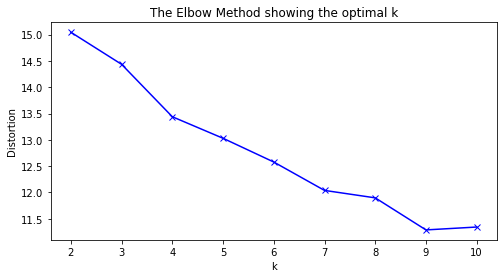

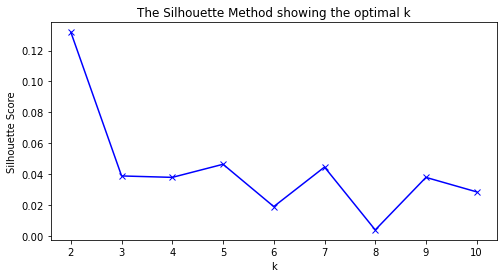

In [86]:
London_grouped_clustering = London_grouped.drop('Neighborhood', axis=1)
# function returns WSS score for k values from 1 to kmax
distortions=[]
sil=[]
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt1
import matplotlib.pyplot as plt2
%matplotlib inline 
K = range(2,11)
for k in K:
    kmeanModel = KMeans(init="k-means++",n_clusters=k,n_init=8)
    kmeanModel.fit(London_grouped_clustering)
    distortions.append([k,kmeanModel.inertia_])
    labels = kmeanModel.labels_
    sil.append([k,silhouette_score(London_grouped_clustering, labels, metric = 'euclidean')])
    
print(sil)
print(distortions)
plt1.figure(figsize=(8,4))
distortionT=list(zip(*distortions))
plt1.plot(K, distortionT[1], 'bx-')
plt1.xlabel('k')
plt1.ylabel('Distortion')
plt1.title('The Elbow Method showing the optimal k')
plt1.show()

plt2.figure(figsize=(8,4))
silT=list(zip(*sil))
plt2.plot(K, silT[1], 'bx-')
plt2.xlabel('k')
plt2.ylabel('Silhouette Score')
plt2.title('The Silhouette Method showing the optimal k')
plt2.show()
#Clustering neighborhoods for k Means clustering 
# set number of clusters
# kclusters = 5


## Performing K Means Clustering with 7 Cluster Labels basis the above observation of Elbow and silhouette score at k=7

In [92]:
#Clustering neighborhoods for k Means clustering 
London_grouped_clustering = London_grouped.drop('Neighborhood', axis=1)
# set number of clusters
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 3, 4, 3, 5, 6, 3, 0], dtype=int32)

In [93]:
#Creating a new dataframe with top 10 venue categories that are most available in each neighborhood
# add clustering labels
Londonneighborhoods_venues_sorted.insert(0, 'Cluster_Labels', kmeans.labels_)

London_merged = dfLondon

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(Londonneighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
London_merged=London_merged.dropna(axis=0)
London_merged.Cluster_Labels=London_merged.Cluster_Labels.astype('int')
print(London_merged.shape)
London_merged.head(25) # check the last columns!
# LA_merged.dtypes


(203, 14)


,Neighborhood,Latitude,Longitude,Cluster_Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR1, Bromley",51.408148,0.025313,3,Clothing Store,Coffee Shop,Pub,Bar,Café,Burger Joint,Pizza Place,Gym / Fitness Center,Indian Restaurant,Bookstore
1,"BR1, Lewisham",51.426757,0.003879,1,Grocery Store,Park,Gym / Fitness Center,Fried Chicken Joint,Fish & Chips Shop,Clothing Store,Café,Yoga Studio,Flea Market,Financial or Legal Service
2,"BR2, Bromley",51.387282,0.022406,1,Soccer Stadium,Gym / Fitness Center,Fruit & Vegetable Store,Park,English Restaurant,Gym,Pub,Forest,Fish Market,Fried Chicken Joint
3,"BR3, Bromley",51.404544,-0.030594,3,Italian Restaurant,Coffee Shop,Pub,Park,Supermarket,Grocery Store,Café,Fish & Chips Shop,Pizza Place,Indian Restaurant
4,"BR3, Croydon",51.378711,-0.027304,4,Grocery Store,Fast Food Restaurant,Pub,Supermarket,Pizza Place,Café,Train Station,Pet Store,Coffee Shop,Pharmacy
7,"BR5, Bromley",51.391709,0.103367,3,Portuguese Restaurant,Train Station,Business Service,Stationery Store,Shopping Plaza,Bookstore,Miscellaneous Shop,Outdoor Supply Store,Gift Shop,Martial Arts School
8,"BR6, Bromley",51.365328,0.090194,5,Platform,Pub,Bar,Coffee Shop,Grocery Store,Health & Beauty Service,Train Station,Bakery,Field,Film Studio
9,"BR7, Bromley",51.414730,0.064495,6,Pub,Italian Restaurant,Coffee Shop,Indian Restaurant,Wine Shop,Bar,French Restaurant,Café,Cricket Ground,Cave
11,"BR8, Bromley",51.398938,0.148864,3,Diner,Fast Food Restaurant,Yoga Studio,Food & Drink Shop,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market
13,"CM14, Havering",51.609021,0.260054,0,Noodle House,Hardware Store,Pub,Convenience Store,Hotel,Yoga Studio,Food,Film Studio,Financial or Legal Service,Fish & Chips Shop


In [94]:
# Optional code to check if there are still any null values in the common venues dataframe.
# This is relevant to be checked upon later executions since the venues are time-dependent and not absolute over a scale of a few years.
# bool_series = pd.isnull(London_merged["Cluster Labels"])
# London_merged[bool_series]

In [95]:
#Visualizing the resulting CLusters
# create map
map_clusters = folium.Map(location=[latitudelondon, longitudelondon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged['Latitude'],London_merged['Longitude'],London_merged['Neighborhood'],London_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ', Cluster --> ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1-2],
        fill=True,
        fill_color=rainbow[cluster-1-3],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Inspecting the types of Venues based on Clusters

In [96]:
#Inspecting Cluster 1
London_merged_cluster1=London_merged.loc[London_merged['Cluster_Labels'] == 0, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster1.reset_index(drop=True,inplace=True)
print('Cluster 1 has '+str(London_merged_cluster1.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster1.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud1L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster1

Cluster 1 has 9 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CM14, Havering",Noodle House,Hardware Store,Pub,Convenience Store,Hotel,Yoga Studio,Food,Film Studio,Financial or Legal Service,Fish & Chips Shop
1,"CR6, Croydon",Gym,Pub,Grocery Store,Construction & Landscaping,Fast Food Restaurant,Rugby Pitch,Yoga Studio,Flower Shop,Film Studio,Financial or Legal Service
2,"DA7, Bexley",Pub,Convenience Store,Café,Grocery Store,Pizza Place,Supermarket,Bus Station,Fish & Chips Shop,Train Station,Kebab Restaurant
3,"EN2, Enfield",Pub,Grocery Store,Coffee Shop,Pizza Place,Stationery Store,Tennis Court,Auto Workshop,Train Station,Indian Restaurant,Bar
4,"IG7, Redbridge",Bakery,Pub,Gym,BBQ Joint,Track,Grocery Store,Auto Garage,Convenience Store,Pharmacy,Skate Park
5,"KT18, Kingston upon Thames",Pub,Grocery Store,Lake,Electronics Store,Yoga Studio,Food,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store
6,"SE28, Bexley",Soccer Field,Grocery Store,Pub,Convenience Store,Construction & Landscaping,History Museum,Yoga Studio,Film Studio,Financial or Legal Service,Fish & Chips Shop
7,"TN14, Bromley",Performing Arts Venue,Pub,Construction & Landscaping,Campground,Food,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store
8,"WD6, Barnet",Pub,Steakhouse,Supermarket,Campground,Yoga Studio,Food,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market


In [97]:
#Inspecting Cluster 2
London_merged_cluster2=London_merged.loc[London_merged['Cluster_Labels'] == 1, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster2.reset_index(drop=True,inplace=True)
print('Cluster 2 has '+str(London_merged_cluster2.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster2.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud2L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster2

Cluster 2 has 18 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR1, Lewisham",Grocery Store,Park,Gym / Fitness Center,Fried Chicken Joint,Fish & Chips Shop,Clothing Store,Café,Yoga Studio,Flea Market,Financial or Legal Service
1,"BR2, Bromley",Soccer Stadium,Gym / Fitness Center,Fruit & Vegetable Store,Park,English Restaurant,Gym,Pub,Forest,Fish Market,Fried Chicken Joint
2,"CR0, Croydon",Park,Fast Food Restaurant,Grocery Store,Café,Chinese Restaurant,Tram Station,Golf Course,Bakery,Diner,Pub
3,"CR2, Croydon",Fish & Chips Shop,Train Station,Park,Yoga Studio,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish Market,Fishing Store,Flea Market
4,"CR3, Croydon",Pub,Park,Train Station,Platform,Soccer Stadium,Massage Studio,Pet Service,Grocery Store,Food & Drink Shop,Financial or Legal Service
5,"CR4, Sutton",Park,Train Station,Breakfast Spot,Food Truck,Tram Station,River,Supermarket,Rugby Pitch,Yoga Studio,Fishing Store
6,"CR8, Sutton",Gym,Grocery Store,Construction & Landscaping,Park,Yoga Studio,Flower Shop,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store
7,"KT17, Sutton",Grocery Store,Café,Gym / Fitness Center,Indian Restaurant,Train Station,Convenience Store,Park,Flea Market,Film Studio,Financial or Legal Service
8,"NW9, Brent",Park,Playground,Indian Restaurant,Fruit & Vegetable Store,Dessert Shop,Greek Restaurant,Bus Stop,Sandwich Place,Café,Hookah Bar
9,"RM15, Havering",Clothing Store,Restaurant,Park,Video Store,Yoga Studio,Flower Shop,Field,Film Studio,Financial or Legal Service,Fish & Chips Shop


In [98]:
#Inspecting Cluster 3
London_merged_cluster3=London_merged.loc[London_merged['Cluster_Labels'] == 2, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster3.reset_index(drop=True,inplace=True)
print('Cluster 3 has '+str(London_merged_cluster3.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster3.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud3L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster3

Cluster 3 has 2 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CR6, Bromley",Farm,Construction & Landscaping,Massage Studio,Yoga Studio,Food,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store
1,"EN6, Enfield",Farm,Yoga Studio,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop


In [99]:
#Inspecting Cluster 4
London_merged_cluster4=London_merged.loc[London_merged['Cluster_Labels'] == 3, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster4.reset_index(drop=True,inplace=True)
print('Cluster 4 has '+str(London_merged_cluster4.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster4.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud4L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster4

Cluster 4 has 67 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR1, Bromley",Clothing Store,Coffee Shop,Pub,Bar,Café,Burger Joint,Pizza Place,Gym / Fitness Center,Indian Restaurant,Bookstore
1,"BR3, Bromley",Italian Restaurant,Coffee Shop,Pub,Park,Supermarket,Grocery Store,Café,Fish & Chips Shop,Pizza Place,Indian Restaurant
2,"BR5, Bromley",Portuguese Restaurant,Train Station,Business Service,Stationery Store,Shopping Plaza,Bookstore,Miscellaneous Shop,Outdoor Supply Store,Gift Shop,Martial Arts School
3,"BR8, Bromley",Diner,Fast Food Restaurant,Yoga Studio,Food & Drink Shop,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market
4,"CR0, Sutton",Furniture / Home Store,Clothing Store,Sporting Goods Shop,Supermarket,Hardware Store,Shopping Plaza,Electronics Store,Sandwich Place,Fast Food Restaurant,Bistro
...,...,...,...,...,...,...,...,...,...,...,...
62,"UB11, Hillingdon",Sandwich Place,Coffee Shop,Bakery,Airport Terminal,Stadium,Health & Beauty Service,Auto Garage,Soccer Field,Bookstore,Gym / Fitness Center
63,"UB6, Ealing",Clothing Store,Sporting Goods Shop,Sandwich Place,Golf Course,Supermarket,Bookstore,Motorcycle Shop,Café,Shopping Plaza,Fast Food Restaurant
64,"UB8, Hillingdon",Pub,Bus Stop,Coffee Shop,Gym,History Museum,Golf Course,Sandwich Place,Fish & Chips Shop,Supermarket,Gastropub
65,"W11, Kensington and Chelsea",Italian Restaurant,Pub,Bookstore,Bakery,Clothing Store,Cocktail Bar,Breakfast Spot,Bar,Restaurant,Chocolate Shop


In [100]:
#Inspecting Cluster 5
London_merged_cluster5=London_merged.loc[London_merged['Cluster_Labels'] == 4, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster5.reset_index(drop=True,inplace=True)
print('Cluster 5 has '+str(London_merged_cluster5.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster5.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud5L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster5

Cluster 5 has 50 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR3, Croydon",Grocery Store,Fast Food Restaurant,Pub,Supermarket,Pizza Place,Café,Train Station,Pet Store,Coffee Shop,Pharmacy
1,"CR4, Croydon",Fast Food Restaurant,Supermarket,Grocery Store,Bus Stop,Park,Convenience Store,Food,Financial or Legal Service,Fish & Chips Shop,Fish Market
2,"CR4, Lambeth",Grocery Store,Supermarket,Breakfast Spot,Fish & Chips Shop,Train Station,Go Kart Track,Pizza Place,Platform,Cosmetics Shop,Bus Stop
3,"CR5, Croydon",Supermarket,Platform,Hotel,Grocery Store,Pharmacy,Train Station,Coffee Shop,Martial Arts School,Pub,Food Court
4,"DA14, Bexley",Coffee Shop,Grocery Store,Fast Food Restaurant,Pharmacy,Gym / Fitness Center,Pizza Place,Café,Supermarket,Bakery,Burger Joint
5,"DA15, Bexley",Grocery Store,Dessert Shop,Pizza Place,Bakery,Beer Bar,Italian Restaurant,Fish & Chips Shop,Hotel,Coffee Shop,Train Station
6,"DA16, Bexley",Supermarket,Grocery Store,Pub,Coffee Shop,Fast Food Restaurant,Italian Restaurant,Train Station,Pharmacy,Soccer Stadium,Pizza Place
7,"DA17, Bexley",Grocery Store,Eastern European Restaurant,Supermarket,Hardware Store,Trail,Park,Fast Food Restaurant,Food Truck,Food Court,Film Studio
8,"DA8, Bexley",Grocery Store,Furniture / Home Store,Café,Chinese Restaurant,Hardware Store,Clothing Store,Train Station,Athletics & Sports,Pizza Place,Supermarket
9,"E12, Newham",Indian Restaurant,Grocery Store,Restaurant,Gas Station,Hotel,Train Station,Park,Yoga Studio,Fishing Store,Field


In [101]:
#Inspecting Cluster 6
London_merged_cluster6=London_merged.loc[London_merged['Cluster_Labels'] == 5, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster6.reset_index(drop=True,inplace=True)
print('Cluster 6 has '+str(London_merged_cluster6.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster6.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud6L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster6

Cluster 6 has 3 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR6, Bromley",Platform,Pub,Bar,Coffee Shop,Grocery Store,Health & Beauty Service,Train Station,Bakery,Field,Film Studio
1,"CR5, Sutton",Home Service,Construction & Landscaping,Platform,Train Station,Gym / Fitness Center,Fountain,Fried Chicken Joint,Field,Film Studio,Financial or Legal Service
2,"HA7, Barnet",Platform,Fast Food Restaurant,Fish & Chips Shop,Grocery Store,Metro Station,Park,Mini Golf,Golf Course,Yoga Studio,Film Studio


In [102]:
#Inspecting Cluster 7
London_merged_cluster7=London_merged.loc[London_merged['Cluster_Labels'] == 6, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
London_merged_cluster7.reset_index(drop=True,inplace=True)
print('Cluster 7 has '+str(London_merged_cluster7.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

#FORMING WORDCLOUD FOR INSPECTION
venues2dlist=[]
for i in range(1,11):
    venues2dlist.append(London_merged_cluster7.iloc[:,i])
# Flattening the list in 1d
venues = [j for sub in venues2dlist for j in sub]
# Removing spaces in individual venues categories
venues = [x.replace(' ','') for x in venues]
venues = [x.replace('/','') for x in venues]
# print(venues)
text= "" 
text=' '.join(venues)
# show only 10 words in the wordcloud . 
wordcloud7L = WordCloud(width=800, height=500,background_color='white').generate(text)

#Viewing Neighborhoods in CLuster
London_merged_cluster7

Cluster 7 has 54 neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"BR7, Bromley",Pub,Italian Restaurant,Coffee Shop,Indian Restaurant,Wine Shop,Bar,French Restaurant,Café,Cricket Ground,Cave
1,"DA16, Greenwich",English Restaurant,Park,Farm,Pub,Garden Center,Forest,Train Station,Café,Golf Course,Platform
2,"DA5, Bexley",Pub,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Breakfast Spot,Italian Restaurant,Greek Restaurant,Tennis Court,Train Station,Flea Market
3,"E10, Waltham Forest",Café,Grocery Store,Park,Pub,Hotel,Supermarket,Coffee Shop,Fish & Chips Shop,Restaurant,Farm
4,"E11, Redbridge",Pub,Grocery Store,Park,Restaurant,English Restaurant,Café,Coffee Shop,Gym / Fitness Center,Bakery,Sushi Restaurant
5,"E11, Waltham Forest",Pub,Café,Grocery Store,Gym,Park,Coffee Shop,Thai Restaurant,Fast Food Restaurant,Chinese Restaurant,Restaurant
6,"E13, Newham",Pub,Gym / Fitness Center,Convenience Store,Café,Grocery Store,Bus Stop,Bookstore,Rugby Pitch,Hostel,Vietnamese Restaurant
7,"E2, Tower Hamlets",Coffee Shop,Pub,Yoga Studio,Park,Bakery,Market,Italian Restaurant,Restaurant,Hotel,Wine Bar
8,"E4, Waltham Forest",Pub,Grocery Store,Café,Gym,Gym / Fitness Center,Park,Sandwich Place,Coffee Shop,Pizza Place,English Restaurant
9,"E5, Hackney",Pub,Park,Grocery Store,Café,Coffee Shop,Turkish Restaurant,Pizza Place,Vegetarian / Vegan Restaurant,Nature Preserve,Burger Joint


In [103]:
# #Inspecting Cluster 8
# London_merged_cluster8=London_merged.loc[London_merged['Cluster_Labels'] == 7, London_merged.columns[[0] + list(range(4, London_merged.shape[1]))]]
# London_merged_cluster8.reset_index(drop=True,inplace=True)
# print('Cluster 8 has '+str(London_merged_cluster8.shape[0])+' neighborhoods. Most occuring 10 types of venues in each of these neighborhoods are listed below.')

# #FORMING WORDCLOUD FOR INSPECTION
# venues2dlist=[]
# for i in range(1,11):
#     venues2dlist.append(London_merged_cluster8.iloc[:,i])
# # Flattening the list in 1d
# venues = [j for sub in venues2dlist for j in sub]
# # Removing spaces in individual venues categories
# venues = [x.replace(' ','') for x in venues]
# venues = [x.replace('/','') for x in venues]
# # print(venues)
# text= "" 
# text=' '.join(venues)
# # show only 10 words in the wordcloud . 
# wordcloud8L = WordCloud(width=800, height=500,background_color='white').generate(text)

# #Viewing Neighborhoods in CLuster
# London_merged_cluster8

### Plotting the WordCloud image for all clusters of LA & London

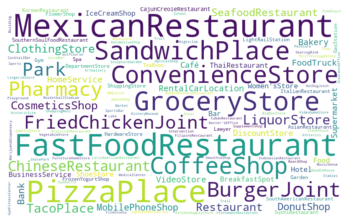

In [104]:
import matplotlib.pyplot as pltC1LA
pltC1LA.figure()
pltC1LA.imshow(wordcloud1LA, interpolation="bilinear")
pltC1LA.axis("off")
pltC1LA.margins(x=0, y=0)
pltC1LA.show()

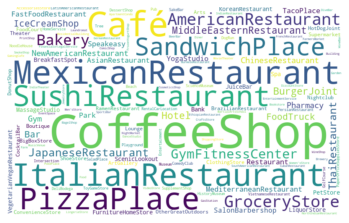

In [105]:
import matplotlib.pyplot as pltC2LA
pltC2LA.figure()
pltC2LA.imshow(wordcloud2LA, interpolation="bilinear")
pltC2LA.axis("off")
pltC2LA.margins(x=0, y=0)
pltC2LA.show()

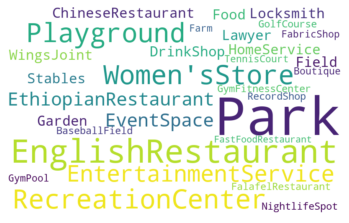

In [106]:
import matplotlib.pyplot as pltC3LA
pltC3LA.figure()
pltC3LA.imshow(wordcloud3LA, interpolation="bilinear")
pltC3LA.axis("off")
pltC3LA.margins(x=0, y=0)
pltC3LA.show()

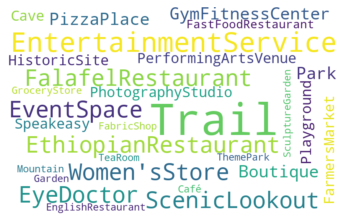

In [107]:
import matplotlib.pyplot as pltC4LA
pltC4LA.figure()
pltC4LA.imshow(wordcloud4LA, interpolation="bilinear")
pltC4LA.axis("off")
pltC4LA.margins(x=0, y=0)
pltC4LA.show()

In [108]:
# import matplotlib.pyplot as pltC5LA
# pltC5LA.figure()
# pltC5LA.imshow(wordcloud5LA, interpolation="bilinear")
# pltC5LA.axis("off")
# pltC5LA.margins(x=0, y=0)
# pltC5LA.show()

In [109]:
# import matplotlib.pyplot as pltC6LA
# pltC6LA.figure()
# pltC6LA.imshow(wordcloud6LA, interpolation="bilinear")
# pltC6LA.axis("off")
# pltC6LA.margins(x=0, y=0)
# pltC6LA.show()

In [110]:
# import matplotlib.pyplot as pltC7LA
# pltC7LA.figure()
# pltC7LA.imshow(wordcloud7LA, interpolation="bilinear")
# pltC7LA.axis("off")
# pltC7LA.margins(x=0, y=0)
# pltC7LA.show()

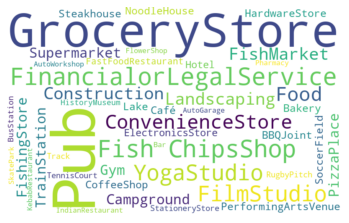

In [111]:
import matplotlib.pyplot as pltC1L
pltC1L.figure()
pltC1L.imshow(wordcloud1L, interpolation="bilinear")
pltC1L.axis("off")
pltC1L.margins(x=0, y=0)
pltC1L.show()

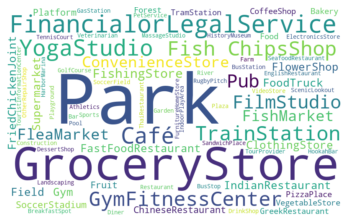

In [112]:
import matplotlib.pyplot as pltC2L
pltC2L.figure()
pltC2L.imshow(wordcloud2L, interpolation="bilinear")
pltC2L.axis("off")
pltC2L.margins(x=0, y=0)
pltC2L.show()

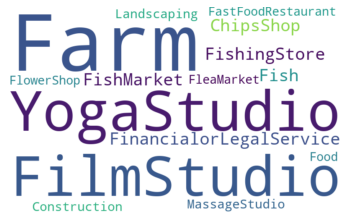

In [113]:
import matplotlib.pyplot as pltC3L
pltC3L.figure()
pltC3L.imshow(wordcloud3L, interpolation="bilinear")
pltC3L.axis("off")
pltC3L.margins(x=0, y=0)
pltC3L.show()

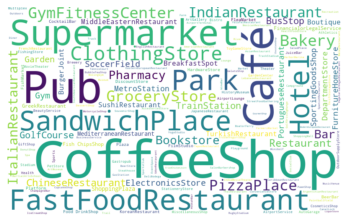

In [114]:
import matplotlib.pyplot as pltC4L
pltC4L.figure()
pltC4L.imshow(wordcloud4L, interpolation="bilinear")
pltC4L.axis("off")
pltC4L.margins(x=0, y=0)
pltC4L.show()

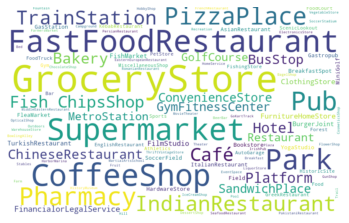

In [115]:
import matplotlib.pyplot as pltC5L
pltC5L.figure()
pltC5L.imshow(wordcloud5L, interpolation="bilinear")
pltC5L.axis("off")
pltC5L.margins(x=0, y=0)
pltC5L.show()

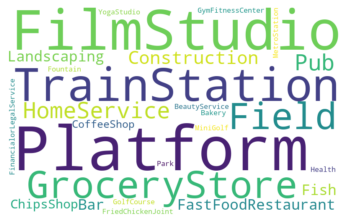

In [116]:
import matplotlib.pyplot as pltC6L
pltC6L.figure()
pltC6L.imshow(wordcloud6L, interpolation="bilinear")
pltC6L.axis("off")
pltC6L.margins(x=0, y=0)
pltC6L.show()

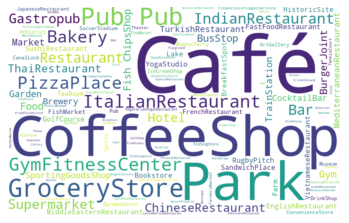

In [117]:
import matplotlib.pyplot as pltC7L
pltC7L.figure()
pltC7L.imshow(wordcloud7L, interpolation="bilinear")
pltC7L.axis("off")
pltC7L.margins(x=0, y=0)
pltC7L.show()

In [118]:
# import matplotlib.pyplot as pltC8L
# pltC8L.figure()
# pltC8L.imshow(wordcloud8L, interpolation="bilinear")
# pltC8L.axis("off")
# pltC8L.margins(x=0, y=0)
# pltC8L.show()

In [119]:
#Listing each cluster neighborhoods details side by side for Inspection eith wordclouds.
print('LA Cluster 1: '+str(LA_merged_cluster1.shape[0])+' neighborhoods.')
print('LA Cluster 2: '+str(LA_merged_cluster2.shape[0])+' neighborhoods.')
print('LA Cluster 3: '+str(LA_merged_cluster3.shape[0])+' neighborhoods.')
print('LA Cluster 4: '+str(LA_merged_cluster4.shape[0])+' neighborhoods.')
print('London Cluster 1: '+str(London_merged_cluster1.shape[0])+' neighborhoods.')
print('London Cluster 2: '+str(London_merged_cluster2.shape[0])+' neighborhoods.')
print('London Cluster 3: '+str(London_merged_cluster3.shape[0])+' neighborhoods.')
print('London Cluster 4: '+str(London_merged_cluster4.shape[0])+' neighborhoods.')
print('London Cluster 5: '+str(London_merged_cluster5.shape[0])+' neighborhoods.')
print('London Cluster 6: '+str(London_merged_cluster6.shape[0])+' neighborhoods.')
print('London Cluster 7: '+str(London_merged_cluster7.shape[0])+' neighborhoods.')


LA Cluster 1: 40 neighborhoods.
LA Cluster 2: 40 neighborhoods.
LA Cluster 3: 4 neighborhoods.
LA Cluster 4: 4 neighborhoods.
London Cluster 1: 9 neighborhoods.
London Cluster 2: 18 neighborhoods.
London Cluster 3: 2 neighborhoods.
London Cluster 4: 67 neighborhoods.
London Cluster 5: 50 neighborhoods.
London Cluster 6: 3 neighborhoods.
London Cluster 7: 54 neighborhoods.


### Cluster 1 - Los Angeles:
#### Cluster 1 with 40 Neighbourhoods forms one major portion of LA City with majority of top venues revolving around fast food joints, and grocery/ convenience stores. These are most likely residential neighbourhoods where most local population would be coming by for quick bites and routine shopping.

### Cluster 2 - Los Angeles:
#### Cluster 2 also with another 40 Neighbourhoods forms the second major portion of LA City with numerous Cafes, and Continental as well as Oriental fine dine restaurants. These are most likely more corporate neighbourhoods where most local and floating population would be coming by for spending time during office hours.

### Cluster 3 - Los Angeles:
#### Cluster 3 is a small cluster with 4 Neighbourhoods and it is likely formed with neighbourhoods surrounding the central LA city area. There is clear majority of Parks, Playgrounds, Event spaces and Courts for various outdoor sports, Recreation Centres, Continental Restaurants & Nightlife spots, Drink shops etc. These are probably the outskirts of the city, which is again reconfirmed in the clustered Map of LA.

### Cluster 4 - Los Angeles:
#### Cluster 4 with 4 remaining Neighbourhoods is that part of LA City where most tourists would likely be interested to visit in daytime. This cluster is filled with multiple distinct genres of places to explore in and around LA city. These include Trails, Event Spaces, Scenic Lookouts, one or more Caves, Historic Sites, a Mountain etc. These are the neighbourhoods surrounded by Nature and must be most likely places of high demand for Real Estate. A further detailed study to explore Real Estate data into these neighbourhoods would be slightly an advanced scope.

#### **It can be distinctively noted that city of LA has a good geographical balance of residential and Corporate neighbourhoods (our clusters 1 and 2), evenly spread in the two different centres forming the heart of the City.**

### Cluster 1 - Greater London:
#### Cluster 1 has 9 Neighbourhoods all of which are distinctly located in the peripheral districts of Greater London. This cluster has a concentration of a mix of routine shopping and essentials stores, maintenance stores as well as a well complemented display of Night life support depicted by numerous Pubs in the cluster. There are also places of outdoor activities and recreation.

### Cluster 2 - Greater London:
#### Cluster 2 with 18 Neighbourhoods is also comprised of Neighbourhoods located in peripheral districts of Greater London. One point of distinction evident at these neighbourhoods from those in cluster 1 is the majority of Parks above all else. Also abundant are the Grocery Stores, Fitness Centres and Gyms, Fish and Chips Shops. Restaurants of Worldwide cuisines and sports spaces are comparatively lower in this cluster. This could possibly be residential zones in Greater London.

### Cluster 3 - Greater London:
#### Cluster 3 with only 2 Neighbourhoods is probably the least city like cluster with both these neighbourhoods lying far from both the geographical boundaries and the semantical definition of a City. These 2 neighbourhoods majorly have Agricultural Farms, Film Studios, Yoga Studios, Massage studios and Seafood/Chips shops. One of the two neighbourhoods has an Airport quite nearby - an observation that was worth noting for some frequent visiting travellers.

### Cluster 4 - Greater London:
#### Cluster 4 with the highest number of 67 Neighbourhoods, is the closest cluster bearing resemblance of a global city, with the neighbourhoods likely in the central parts of various district counties in Greater London. This cluster's neighbourhoods are abundant in Night life with numerous PUBs, Cafes, Hotels, Clothing Stores and other shopping points.

### Cluster 5 - Greater London:
#### Cluster 5 with 50 Neighbourhoods most resembles a residential cluster, with highly populated Grocery stores, Super Markets, Other Essentials, Convenience stores, Oriental restaurants etc. Although with a high number of neighbourhoods, this cluster has geographical spread only in the peripheral districts again!

### Cluster 6 - Greater London:
#### Cluster 6 has 3 Neighbourhoods all located in outskirts of Greater London. Given the abundance of Train stations, Film Studios and construction sites, this is likely a cluster comprising of locations undergoing recent urbanization which could be sparsely populated given the low number of convenience stores and fast foods as well as Fine Dine places here.

### Cluster 7 - Greater London:
#### Cluster 7, our last cluster of this study, has 53 Neighbourhoods. The neighbourhoods are mostly dispersed around the central part of Greater London with a principal spread around east west direction. These neighbourhoods have high abundance of Cafes, PUBs, Parks and Food places of worldwide cuisine making it ideal for city life lovers to get the flavour of Greater London.

#### **One observation worth jotting down about Greater London is that, unlike Los Angeles, it has an extensive network of Train Stations and Soccer fields which are deep rooted in the entire country's culture if not limited to Greater London itself.!**

#### **For an individual looking to relocate from one of these cities to the other, this study project would serve as a rough time saving guide as to what to expect in various parts of the cities. We can relate Cluster 1 of LA with Cluster 5 of Greater London. Also, some similarity can be seen between cluster 2 of LA and clusters 4 and 7 of Greater London. When it comes to the neighbourhoods on the outskirts of each of these cities, LA is more likely a preferred destination for tourists with historical interests.**

#### **It is fascinating how these simple analytical tools of Data Science gave us such profound insights without having visited the actual geographies and with minimal epidemiological / monetary efforts!**